In [1]:
import os
from pathlib import Path

import pandas as pd
import pandas as pd
from pathlib import Path
import os 
import json
import numpy as np


pd.set_option('display.max_colwidth', None)

# add repo root to beginning of sys path to allow other modules to be found by python import machinery
import sys 
sys.path
ROOT_PATH = os.path.abspath('..')
sys.path.insert(0, ROOT_PATH)

# or instead of above can directly change cur dir path to root - but dont do both ! 
#ROOT_PATH= str(Path(os.getcwd()).parents[0])
#os.chdir(ROOT_PATH)
# os instead of above can directly change cur dir path to root
#ROOT_PATH= str(Path(os.getcwd()).parents[0])
#os.chdir(ROOT_PATH)
print(ROOT_PATH)

RESULTS_DIR = os.path.join(str(Path(ROOT_PATH).parents[1]), 'datasets/forecasting/results')
print(RESULTS_DIR )

/Users/rk1103/Documents/AWS-ML-services/projects/forecast
/Users/rk1103/Documents/AWS-ML-services/datasets/forecasting/results


In [46]:
from create_predictor_forecast_jobs import *
from common import *
from teardown_resources import *

In [3]:
# forecast horizon 
FORECAST_LENGTH = 90
# forecast time unit granularity
DATASET_FREQUENCY = "D"
TIMESTAMP_FORMAT = "yyyy-MM-dd"
dataset_name = "manning_csv_full"
predictor_name = f"npts_prophet_5bt_90h"
forecast_name = f"npts_prophet_5bt_90h"
explain_name='explain_manning'
# Specify the schema of your dataset here. Make sure the order of columns matches the raw data files.
ts_schema ={
   "Attributes":[
      {
         "AttributeName":"item_id",
         "AttributeType":"string"
      },
      {
         "AttributeName":"timestamp",
         "AttributeType":"timestamp"
      },
      {
         "AttributeName":"target_value",
         "AttributeType":"float"
      }

   ]
}



role_name = "AmazonForecast-ExecutionRole-1645141603603"
iam = boto3.client('iam')
role_arn = iam.get_role(RoleName=role_name)['Role']['Arn']
role_arn




'arn:aws:iam::376337229415:role/service-role/AmazonForecast-ExecutionRole-1645141603603'

In [4]:
dataset_group_arn = "arn:aws:forecast:us-east-1:376337229415:dataset-group/manning"
create_predictor_response , predictor_arn = train_aws_forecast_model(predictor_name, FORECAST_LENGTH, DATASET_FREQUENCY, dataset_group_arn, auto_ml=False, explain=True, algorithm="NPTS", backtest_windows=5,  holidays_code="US")
print(create_predictor_response)
print("")
check_job_status(predictor_arn, job_type="training")

{'PredictorArn': 'arn:aws:forecast:us-east-1:376337229415:predictor/npts_prophet_5bt_90h', 'ResponseMetadata': {'RequestId': '9d8ad5c2-c2ab-440a-9922-de0760f388c9', 'HTTPStatusCode': 200, 'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1', 'date': 'Mon, 16 May 2022 19:29:13 GMT', 'x-amzn-requestid': '9d8ad5c2-c2ab-440a-9922-de0760f388c9', 'content-length': '89', 'connection': 'keep-alive'}, 'RetryAttempts': 0}}

Import job still in progress. Job status CREATE_PENDING
Import job still in progress. Job status CREATE_IN_PROGRESS
Import job still in progress. Job status CREATE_IN_PROGRESS
Import job still in progress. Job status CREATE_IN_PROGRESS
Import job still in progress. Job status CREATE_IN_PROGRESS
Import job still in progress. Job status CREATE_IN_PROGRESS
Import job still in progress. Job status CREATE_IN_PROGRESS
Import job still in progress. Job status CREATE_IN_PROGRESS
Import job still in progress. Job status CREATE_IN_PROGRESS
Import job still in progress. Job stat

### Forecasting and saving results

In [5]:

forecast_arn = create_forecast(forecast_name, predictor_arn)

arn:aws:forecast:us-east-1:376337229415:forecast/npts_prophet_5bt_90h


In [3]:

check_job_status(forecast_arn, job_type="forecast")

Import job still in progress. Job status CREATE_IN_PROGRESS
Import job still in progress. Job status CREATE_IN_PROGRESS
Import job still in progress. Job status CREATE_IN_PROGRESS
Import job still in progress. Job status CREATE_IN_PROGRESS
Data Import job complete with job status ACTIVE


In [4]:
filters = {"item_id":"1"}
forecast_response = run_forecast_query(forecast_arn, filters)

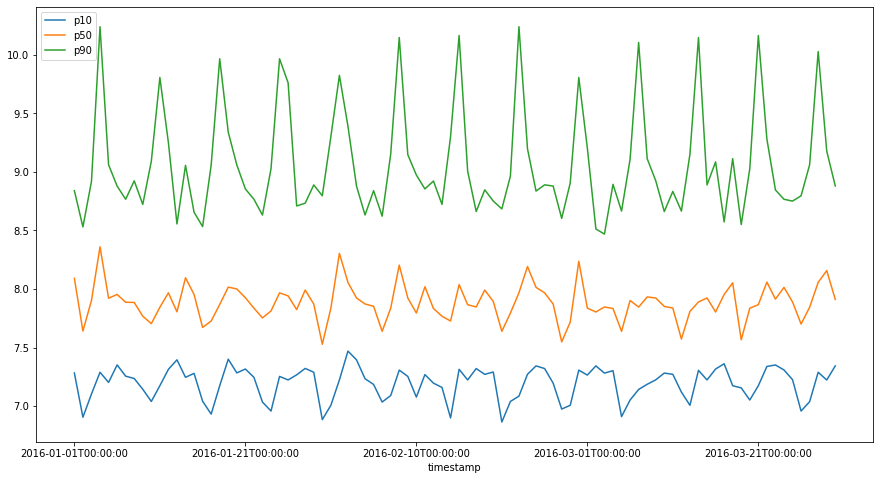

In [5]:
df = create_forecast_plot(forecast_response)

Note: Models generated from non-auto predictor are not eligible for explainability jobs

#### Create export jobs for predictor and forecast

In [13]:


s3_export_path = "s3://aws-forecast-demo-examples/aws_forecast_export_jobs/"



predictor_export = forecast.create_predictor_backtest_export_job(
    PredictorBacktestExportJobName='manning_full_csv_predictor_backtest_export',
    PredictorArn=predictor_arn,
    Destination={
        'S3Config': {
            'Path': s3_export_path,
            'RoleArn': role_arn,
        }
    }
)


forecast_export = forecast.create_forecast_export_job(
    ForecastExportJobName='manning_full_csv_forecast_90h',
    ForecastArn=forecast_arn,
    Destination={
        'S3Config': {
            'Path': s3_export_path,
            'RoleArn': role_arn,
        }
    }
)

print(predictor_export)
print("")
print(forecast_export)

{'PredictorBacktestExportJobArn': 'arn:aws:forecast:us-east-1:376337229415:predictor-backtest-export-job/npts_prophet_5bt_90h/manning_full_csv_predictor_backtest_export', 'ResponseMetadata': {'RequestId': '57b2ef3a-ad7c-4d33-8353-97045f73eb7f', 'HTTPStatusCode': 200, 'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1', 'date': 'Mon, 16 May 2022 21:51:47 GMT', 'x-amzn-requestid': '57b2ef3a-ad7c-4d33-8353-97045f73eb7f', 'content-length': '169', 'connection': 'keep-alive'}, 'RetryAttempts': 0}}

{'ForecastExportJobArn': 'arn:aws:forecast:us-east-1:376337229415:forecast-export-job/npts_prophet_5bt_90h/manning_full_csv_forecast_90h', 'ResponseMetadata': {'RequestId': '5ee9b0b7-b328-4ac8-8272-4eea83bec701', 'HTTPStatusCode': 200, 'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1', 'date': 'Mon, 16 May 2022 21:51:48 GMT', 'x-amzn-requestid': '5ee9b0b7-b328-4ac8-8272-4eea83bec701', 'content-length': '137', 'connection': 'keep-alive'}, 'RetryAttempts': 0}}


In [44]:
error_metrics = forecast.get_accuracy_metrics(PredictorArn= predictor_arn)['PredictorEvaluationResults']
args = [('manning_npts_bt5_horizon90_metrics.json', error_metrics), 
        ('manning_npts_bt5_horizon90_forecastResponse.json', forecast_response)]
import os
from pathlib import Path
repo_root = str(Path(os.path.abspath('.')).parents[2])
basepath = os.path.join(repo_root, 'datasets/forecasting/results/')

save_results(basepath, *args)

saving to manning_npts_bt5_horizon90_metrics.json
saving to manning_npts_bt5_horizon90_forecastResponse.json


#### Delete resources 

In [55]:

predictor_kwargs = {'predictor':predictor_name}    
delete_training_forecast_resources(**predictor_kwargs)

Deleting arn:aws:forecast:us-east-1:376337229415:predictor/npts_prophet_5bt_90h


In [56]:
forecast_kwargs = {'forecast':forecast_name}
delete_training_forecast_resources(**forecast_kwargs)

No forecast job currently exists
